---
title: Heatmap Plots
---

In [8]:
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline

matplotlib_inline.backend_inline.set_matplotlib_formats("retina")
plt.rcParams["figure.dpi"] = 150

## Heatmaps

As an alternative to the 2D waterfall plot (see [1. Introduction](01_plotting_basics.ipynb)), heatmaps provide a top-down, 2D image representation of stacked spectra. This approach eliminates visual occlusion, allowing for direct observation of signal intensities and frequency shifts across the stacking dimension (e.g., time or repetitions).

Similar to the ridge plot, the heatmap utilizes the `xmris` configuration object via the `.xmr.plot.heatmap()` accessor. This separates the plotting parameters from the function signature.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import xmris
from xmris.visualization.plot import PlotHeatmapConfig, PlotRidgeConfig

### 1. Generating Synthetic Data
We simulate the same kinetic process: one peak decaying and another growing, adding proper `xarray` metadata.

In [15]:
rng = np.random.default_rng()
ppm = np.linspace(190, 160, 500)
time = np.linspace(0, 132, 40)
spectra = np.zeros((len(time), len(ppm)))


def gaussian(x, mu, sigma, A):
    """Calculate simple gaussian curve."""
    return A * np.exp(-((x - mu) ** 2) / (2 * sigma**2))


for i, t in enumerate(time):
    decay = np.exp(-t / 50)
    growth = 1 - np.exp(-t / 50)
    spectra[i, :] = (
        gaussian(ppm, 183, 0.8, 10 * decay)
        + gaussian(ppm, 171, 0.6, 8 * growth)
        + rng.normal(0, 0.15, len(ppm))
    )

da_kinetic = xr.DataArray(
    spectra,
    dims=["time", "chemical_shift"],
    coords={"time": time, "chemical_shift": ppm},
    name="Signal",
)

da_kinetic.coords["time"].attrs["units"] = "s"
da_kinetic.coords["chemical_shift"].attrs["units"] = "ppm"

da_kinetic

<xarray.DataArray 'Signal' (time: 40, chemical_shift: 500)> Size: 160kB
array([[-0.22295707,  0.03146875, -0.0357382 , ..., -0.11600683,
         0.07193003, -0.23651698],
       [ 0.22440757, -0.18230583, -0.11035737, ...,  0.26711666,
         0.10512666, -0.12946869],
       [ 0.15032591,  0.09068114,  0.08594016, ...,  0.18668722,
         0.0771381 , -0.31573752],
       ...,
       [ 0.26448738,  0.15681907, -0.35373905, ..., -0.18826649,
        -0.09871644,  0.01374063],
       [ 0.2104077 ,  0.04214079,  0.03122843, ...,  0.13124536,
         0.02343524,  0.1048777 ],
       [ 0.01464275, -0.1430171 , -0.19943123, ...,  0.21136133,
         0.13777345, -0.04835276]])
Coordinates:
  * time            (time) float64 320B 0.0 3.385 6.769 ... 125.2 128.6 132.0
  * chemical_shift  (chemical_shift) float64 4kB 190.0 189.9 ... 160.1 160.0

### 2. The Configuration Object
Instantiate the `PlotHeatmapConfig`. The heatmap has specialized controls, such as `cmap_start` and `cmap_end`, which are crucial for preventing standard colormaps (like `magma` or `viridis`) from rendering blindingly white or totally black on printed paper. It also features a customizable overlaid grid.

In [11]:
CFG_HEAT = PlotHeatmapConfig()
CFG_HEAT

PlotHeatmapConfig(figsize=(8, 5), style='seaborn-v0_8-white', fontfamily='sans-serif', cmap='magma', cmap_start=0.1, cmap_end=0.8, labelsize=12, ticklabelsize=10, xlabel=None, ylabel=None, tick_color='lightgray', tick_len_major=5.0, tick_wid_major=1.0, tick_len_minor=2.0, tick_wid_minor=0.8, xminor_locator=5, yminor_locator=4, grid_on=True, grid_color='lightgray', grid_alpha=0.2, grid_linewidth=0.6, cbar_on=True, cbar_label='Signal Intensity (a.u.)')

### 3. Plotting via the Accessor
Customize the config and generate the plot. Notice how the default setting (`grid_on=True`) utilizes a subtle overlaid grid and inward-facing ticks to make reading exact coordinates effortless.

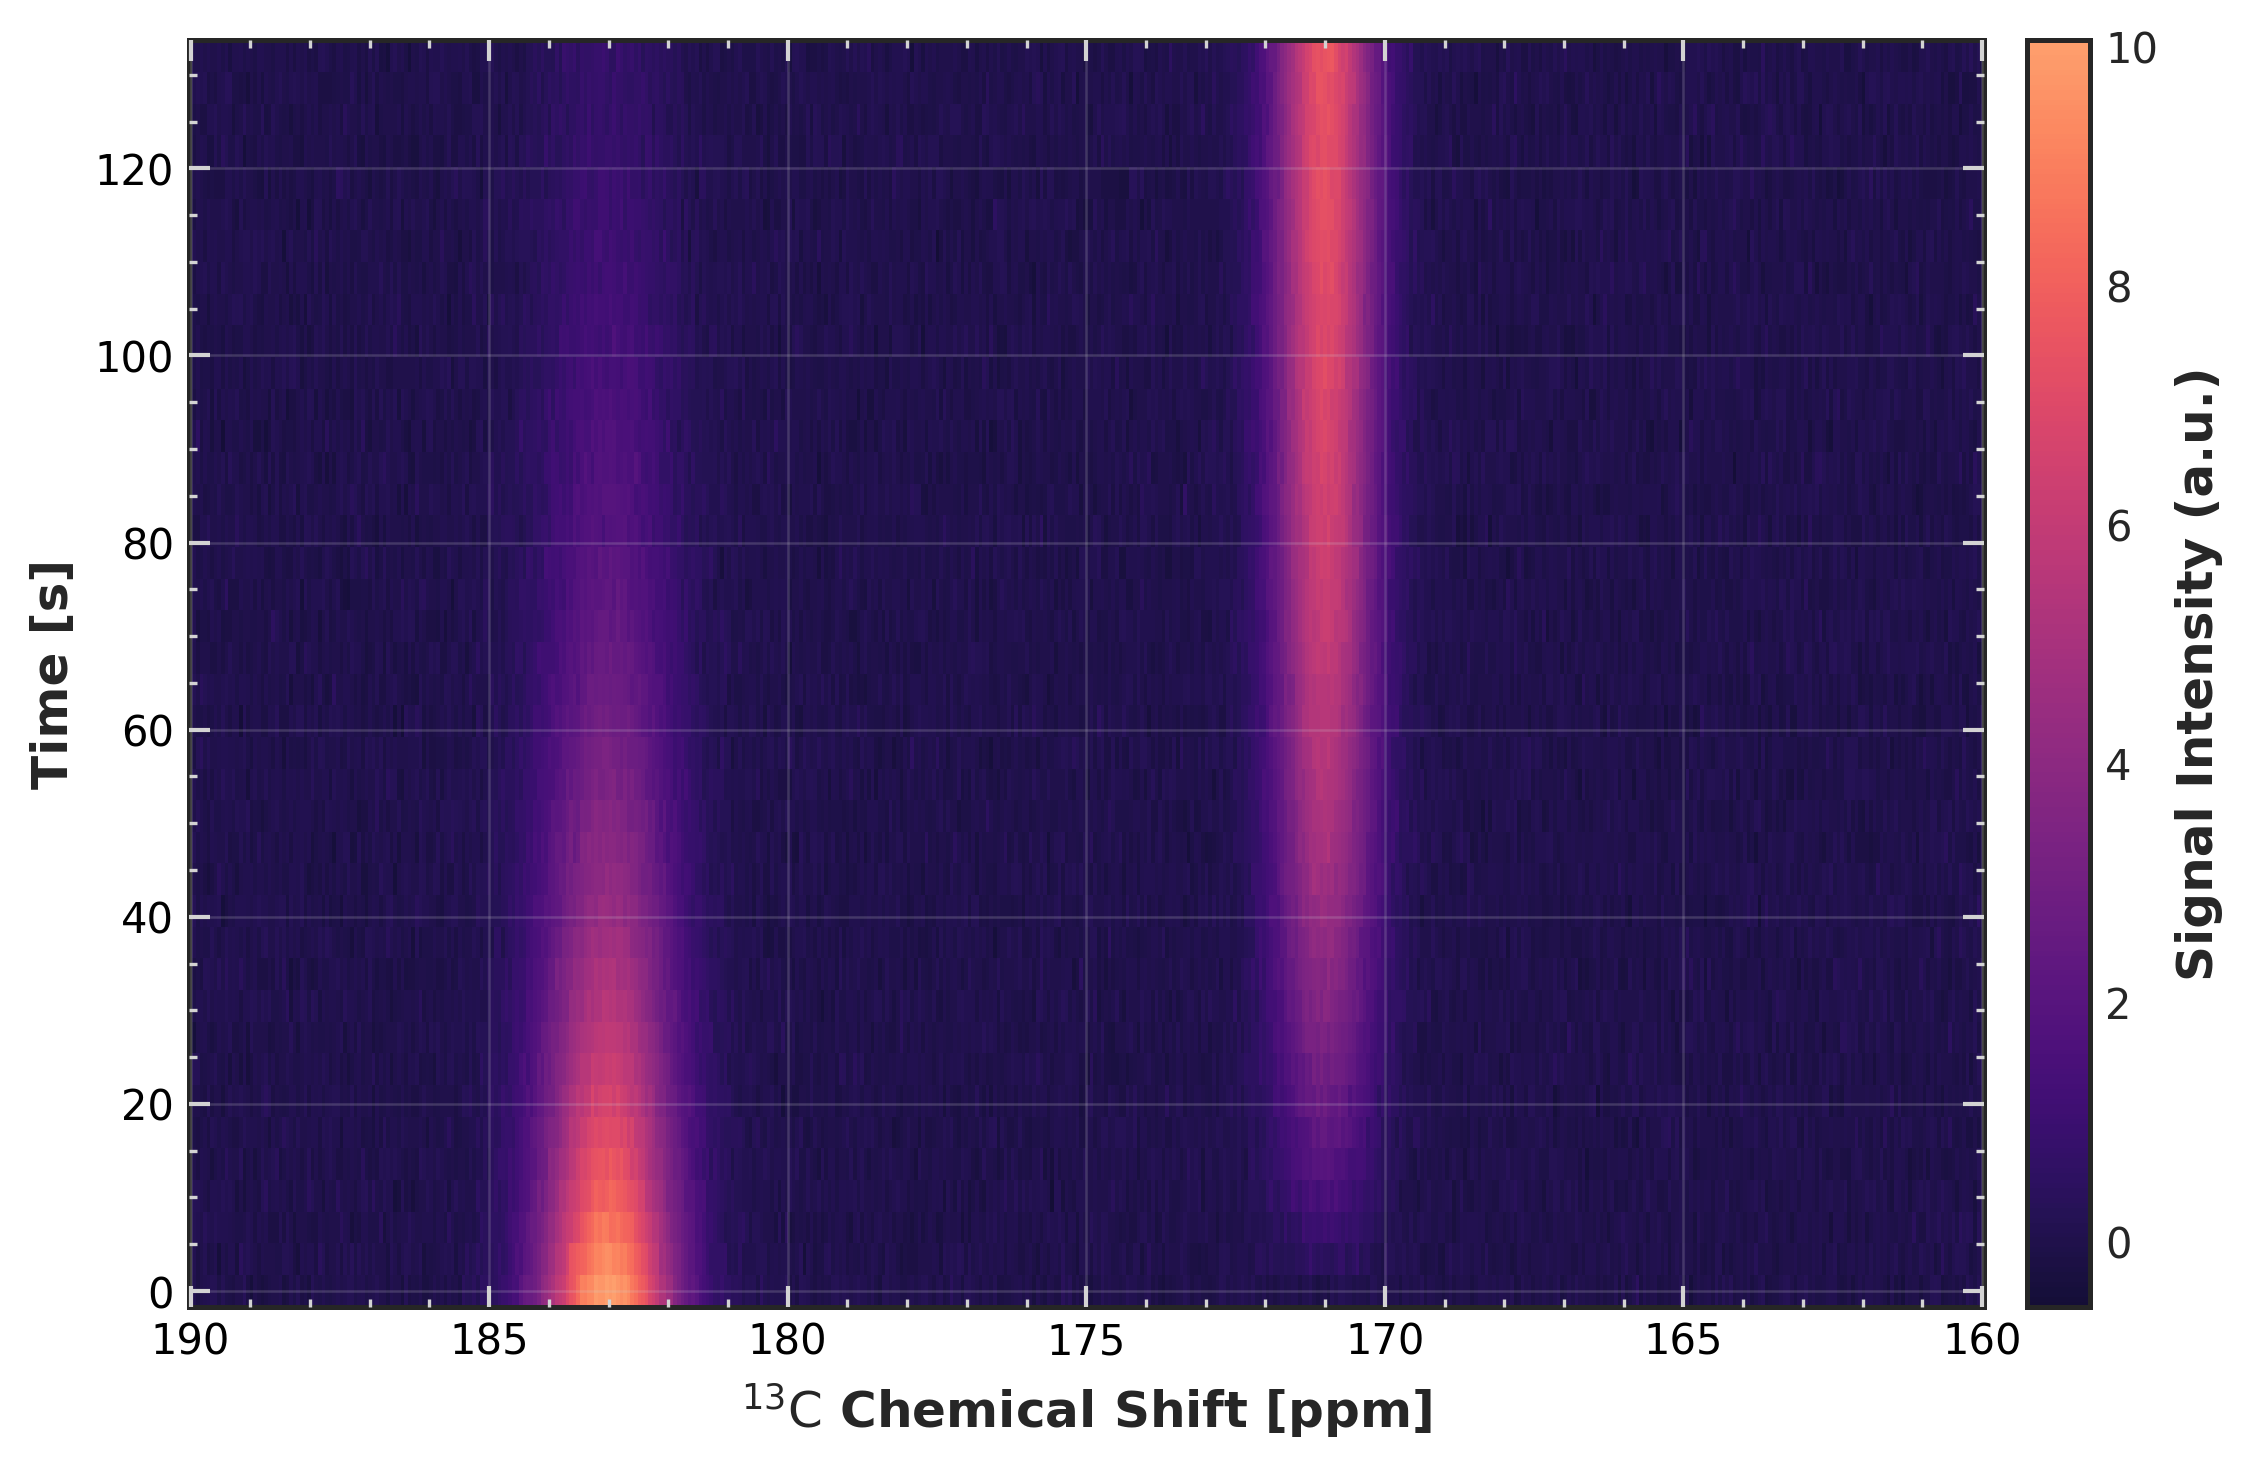

In [12]:
CFG_HEAT.xlabel = r"$^{13}\mathrm{C}$ Chemical Shift"

# Plot using the accessor
ax = da_kinetic.xmr.plot.heatmap(config=CFG_HEAT)
plt.show()

### 4. Multi-Panel Visualizations
Because our plotting functions return standard `matplotlib.Axes` objects, we can easily build a comprehensive, multi-panel figure combining both the qualitative intuition of the Ridge Plot and the quantitative rigor of the Heatmap.

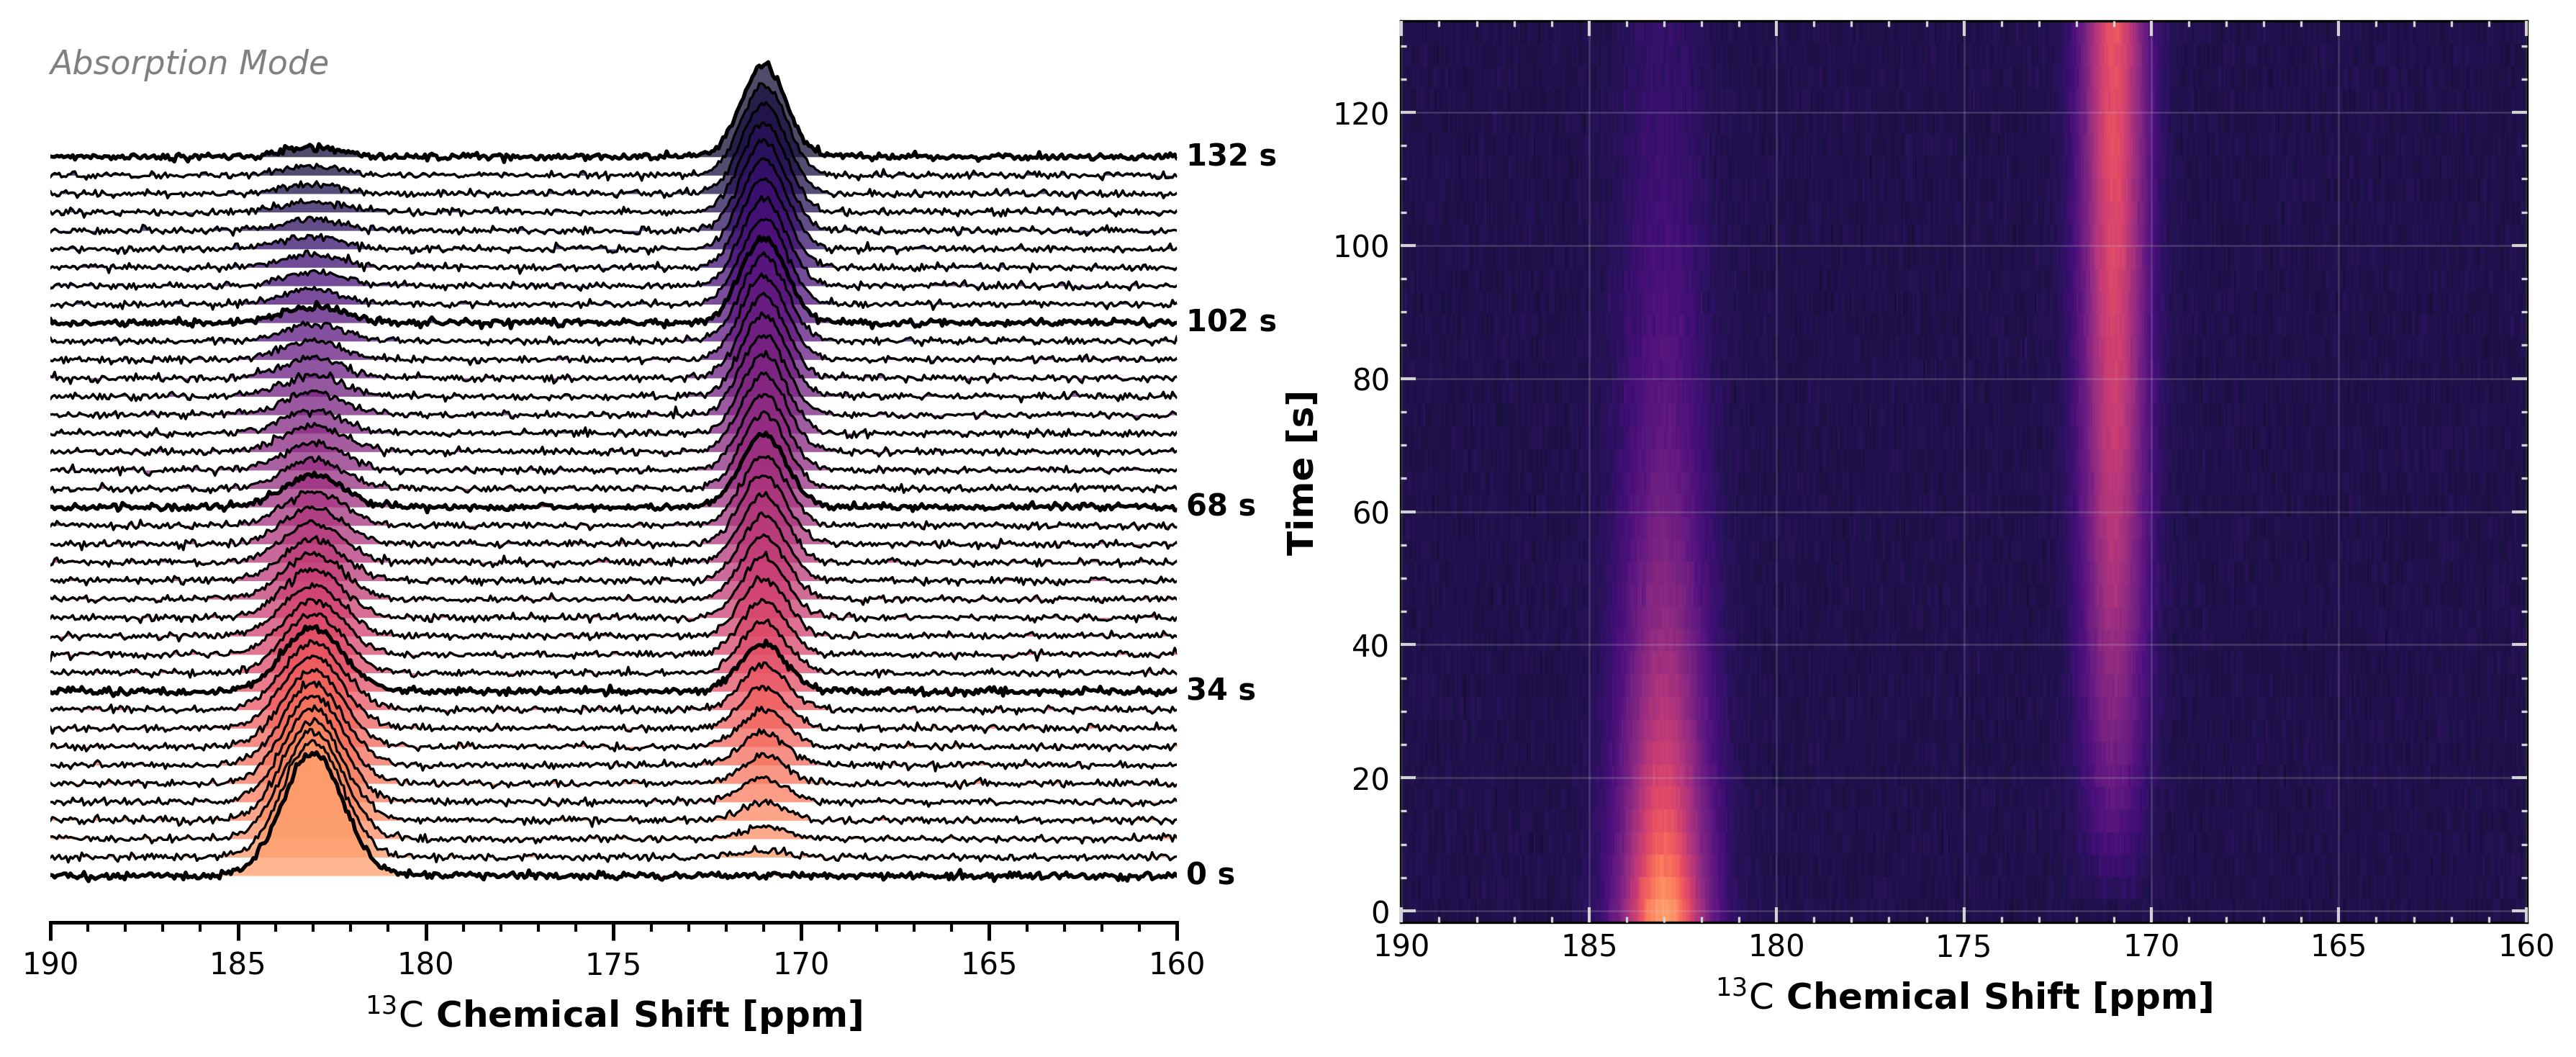

In [13]:
# Setup configurations for both plots
CFG_RIDGE = PlotRidgeConfig(
    xlabel=r"$^{13}\mathrm{C}$ Chemical Shift", annotation="Absorption Mode"
)

CFG_HEAT.cbar_on = False  # Turn off the colorbar to save horizontal space

# Create a 1x2 grid
fig, (ax_left, ax_right) = plt.subplots(
    nrows=1, ncols=2, figsize=(12, 5), gridspec_kw={"width_ratios": [1, 1]}
)

# Render Ridge on the left, Heatmap on the right
da_kinetic.xmr.plot.ridge(ax=ax_left, config=CFG_RIDGE)
da_kinetic.xmr.plot.heatmap(ax=ax_right, config=CFG_HEAT)

plt.tight_layout()
plt.show()

In [14]:
# STRICT TESTS FOR CI
assert isinstance(ax_right, plt.Axes), (
    "plot.heatmap must return a matplotlib Axes object."
)
assert len(ax_right.collections) > 0, "No pcolormesh was generated."
x_label = ax_right.get_xlabel()
assert "13" in x_label and "C" in x_label, "Chemical shift LaTeX formatting failed."